In [16]:
import pandas as pd

sim_df=pd.read_csv('sim.csv')
qualified=pd.read_csv('qualified.csv')

sim_df.head()


,team1,team2,team1Home,team2Home,neutralVenue,friendly,qualifier,finaltourn,team1_win_rate_10,team1_loss_rate_10,...,team2_win_rate_40,team2_loss_rate_40,team2_draw_rate_40,team2_goal_diff_avg_40,team2_confed_form_40,team2_win_rate_50,team2_loss_rate_50,team2_draw_rate_50,team2_goal_diff_avg_50,team2_confed_form_50
0,RUS,KSA,0,0,1,0,0,1,0.6,0.3,...,0.325,0.375,0.300,0.350,0.325,0.32,0.42,0.26,0.36,0.28
1,RUS,EGY,0,0,1,0,0,1,0.6,0.3,...,0.450,0.350,0.200,-0.175,0.375,0.38,0.36,0.26,0.02,0.36
2,RUS,URU,0,0,1,0,0,1,0.6,0.3,...,0.450,0.375,0.175,-0.200,0.425,0.42,0.34,0.24,-0.14,0.46
3,RUS,POR,0,0,1,0,0,1,0.6,0.3,...,0.225,0.600,0.175,0.650,0.225,0.22,0.58,0.20,0.64,0.22
4,RUS,ESP,0,0,1,0,0,1,0.6,0.3,...,0.075,0.750,0.175,1.425,0.100,0.10,0.70,0.20,1.26,0.08


In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
groups={'A':[], 'B':[],'C':[],'D':[],'E':[],'F':[],'G':[],'H':[]}
all_teams=qualified['name'].tolist()

groups['A']=all_teams[0:4]
groups['B']=all_teams[4:8]
groups['C']=all_teams[8:12]
groups['D']=all_teams[12:16]
groups['E']=all_teams[16:20]
groups['F']=all_teams[20:24]
groups['G']=all_teams[24:28]
groups['H']=all_teams[28:32]
print(groups)


    

{'A': ['RUS', 'KSA', 'EGY', 'URU'], 'B': ['POR', 'ESP', 'MAR', 'IRN'], 'C': ['FRA', 'AUS', 'PER', 'DEN'], 'D': ['ARG', 'ISL', 'CRO', 'NGA'], 'E': ['BRA', 'SUI', 'CRC', 'SRB'], 'F': ['GER', 'SWE', 'MEX', 'KOR'], 'G': ['BEL', 'PAN', 'TUN', 'ENG'], 'H': ['POL', 'SEN', 'COL', 'JPN']}


In [55]:
import xgboost as xgb
import numpy as np
import joblib
def add_randomness(probabilities, noise_factor=0.05):

    noise = np.random.normal(0, noise_factor, probabilities.shape) 
    probabilities = probabilities + noise  
    probabilities = np.clip(probabilities, 0, 1)  
    probabilities /= probabilities.sum()  
    return probabilities
def pred_res(team1, team2):
    match = sim_df[((sim_df["team1"] == team1) & (sim_df["team2"] == team2))]
    
    encoder = joblib.load('encoder.joblib')
    match["team1"] = encoder.transform(match["team1"])
    match["team2"] = encoder.transform(match["team2"])
    
    best_xgb = xgb.XGBClassifier()
    best_xgb.load_model("best_xgb.json")
    X_test = match
    
    prediction = best_xgb.predict(X_test)
    probabilities = best_xgb.predict_proba(X_test)[0]
    random_probs=add_randomness(probabilities)
    max_prob = np.max(random_probs) 
    max_index = np.argmax(random_probs)

    if max_prob >= 0.5:
        pred=max_index
    else:
        pred=np.random.choice([0,1,2])
        
    return pred


    
    
    
    

In [75]:
from collections import defaultdict
def sim_group(group):
    group_points= defaultdict(lambda: {"Points": 0, "Goals": 0})
    for group, teams in groups.items():
        for i in range(len(teams)):
            for j in range(i + 1, len(teams)):
                team1, team2 = teams[i], teams[j]
            
                result=pred_res(team1, team2)

                if result == 1:
                    group_points[team1]["Points"] += 3
                    group_points[team1]["Goals"] += 1
                elif result == 2: 
                    group_points[team2]["Points"] += 3
                    group_points[team2]["Goals"] += 1
                else: 
                    group_points[team1]["Points"] += 1
                    group_points[team2]["Points"] += 1
    group_results = pd.DataFrame.from_dict(group_points, orient="index").reset_index()
    group_results.columns = ["Team", "Points", "Goals"]
    group_results.sort_values(by=["Points", "Goals"], ascending=[False, False], inplace=True)
    qualified_teams = []

    for group in groups.keys():
        top_teams = group_results[group_results["Team"].isin(groups[group])].head(2)["Team"].tolist()
        qualified_teams.extend(top_teams)
        
    return qualified_teams

def qualis(qualified_teams):
    np.random.shuffle(qualified_teams)
    knockout_rounds = ["Round of 16", "Quarterfinals", "Semifinals", "Final"]
    knockout_teams = qualified_teams

    for stage in knockout_rounds:
        next_round_teams = []
        for i in range(0, len(knockout_teams), 2):
            team1, team2 = knockout_teams[i], knockout_teams[i+1]
            
            result=pred_res(team1, team2)
            if result == 0:
                winner = np.random.choice([team1, team2])
            else:
                winner = team1 if result == 1 else team2
            next_round_teams.append(winner)

        knockout_teams = next_round_teams
        
    return knockout_teams
    
    

In [72]:
sim_winners=[]

for i in range(1000):
    sim_winners.append(qualis(sim_group(groups)))

In [80]:
dictt={}
for i in sim_winners:
    dictt[i[0]]=0
for i in sim_winners:
    dictt[i[0]]+=1

In [81]:
dictt

{'IRN': 108,
 np.str_('PER'): 163,
 'GER': 446,
 np.str_('ISL'): 16,
 np.str_('BRA'): 131,
 np.str_('JPN'): 42,
 np.str_('AUS'): 5,
 'NGA': 34,
 np.str_('FRA'): 4,
 np.str_('BEL'): 15,
 np.str_('SEN'): 16,
 np.str_('MEX'): 7,
 'ESP': 4,
 np.str_('SUI'): 4,
 np.str_('CRC'): 3,
 np.str_('PAN'): 1,
 np.str_('ENG'): 1}

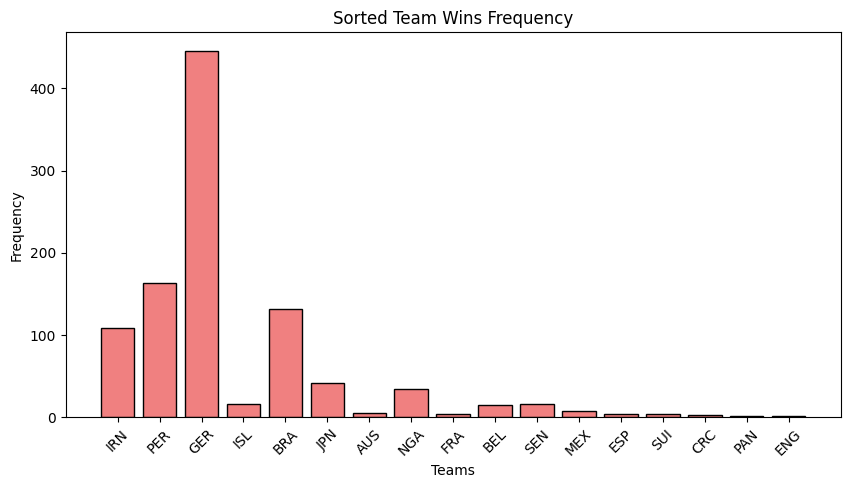

In [82]:
import matplotlib.pyplot as plt
keys = list(dictt.keys())
values = list(dictt.values())

plt.figure(figsize=(10, 5))
plt.bar(keys, values, color="lightcoral", edgecolor="black")
plt.xlabel("Teams")
plt.ylabel("Frequency")
plt.title("Sorted Team Wins Frequency")
plt.xticks(rotation=45)
plt.show()